In [1]:
import matplotlib as mpl
from datasets import load_dataset
from genaibook.core import show_images

In [2]:
mpl.rcParams["image.cmap"] = "gray_r"

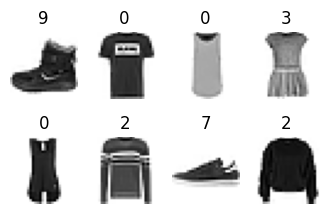

In [3]:
fashion_mnist = load_dataset("fashion_mnist")
clothes = fashion_mnist["train"]['image'][:8]
classes = fashion_mnist["train"]["label"][:8]
show_images(clothes, titles=classes, figsize=(4, 2.5))

In [4]:
import torch
from torchvision import transforms

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Pad(2), # add 2 pixels to all sides to prevent distortion of edges
        transforms.Normalize([0.5], [0.5]) # Map to (-1, 1)
    ]
)

In [6]:
def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    return {"images": images, "labels": examples["label"]}

In [7]:
train_dataset = fashion_mnist["train"].with_transform(transform)

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# Create a Class Conditioned Model

In [9]:
from diffusers import UNet2DModel

/Users/jorocca/Desktop/Projects/AI Practice/Transformers-Diffusions/.venv/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [10]:
model = UNet2DModel(
    in_channels=1, # 1 channel for greyscale images
    out_channels=1,
    sample_size=32, # image size
    block_out_channels=(32, 64, 128, 256),
    num_class_embeds=10 # Enable class conditioning
)

In [11]:
x = torch.randn((1, 1, 32, 32))
with torch.inference_mode():
    out = model(x, timestep=7, class_labels=torch.tensor([2])).sample
out.shape

torch.Size([1, 1, 32, 32])

## Add noise

In [12]:
from diffusers import DDPMScheduler

In [13]:
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

In [14]:
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))

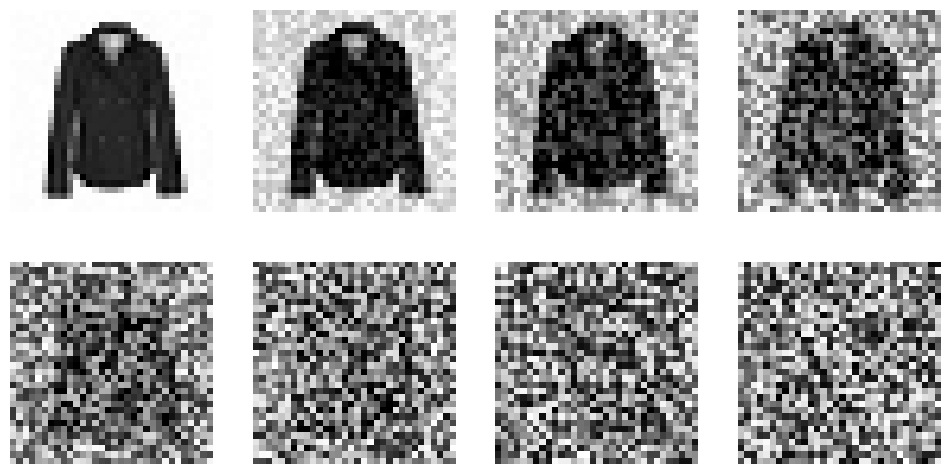

In [15]:
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

# Le Train

In [16]:
from torch.nn import functional as F
from tqdm import tqdm
from genaibook.core import get_device

In [17]:
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02
)

In [18]:
num_epochs = 25
lr = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
losses = []
device = get_device()
model = model.to(device)

In [19]:
for epoch in (progress := tqdm(range(num_epochs))):
    for step, batch in (
        inner := tqdm(
            enumerate(train_dataloader),
            position=0,
            leave=True,
            total=len(train_dataloader)
        )
    ):
        clean_images = batch['images'].to(device)
        class_labels = batch['labels'].to(device)

        noise = torch.randn(clean_images.shape).to(device)

        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device
        ).long()

        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(
            noisy_images,
            timesteps,
            class_labels=class_labels,
            return_dict=False
        )[0]

        loss = F.mse_loss(noise_pred, noise)

        inner.set_postfix(loss=f'{loss.cpu().item():3f}')

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 25/25 [2:17:40<00:00, 330.44s/it]


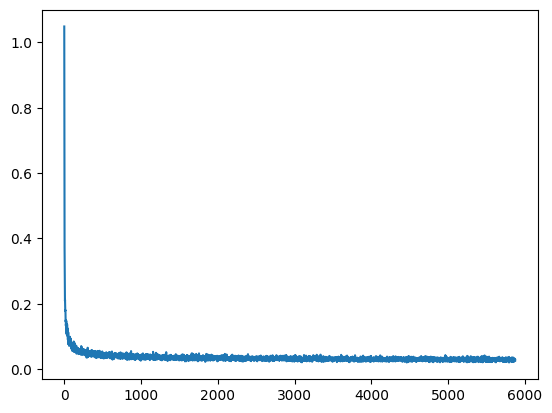

In [20]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [21]:
def generate_from_class(class_to_generate, n_samples=6):
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)

    for _, t in tqdm(enumerate(scheduler.timesteps)):
        with torch.inference_mode():
            noise_pred = model(sample, t, class_labels=class_labels).sample

        sample = scheduler.step(noise_pred, t, sample).prev_sample
    return sample.clip(-1, 1) * 0.5 + 0.5

1000it [00:48, 20.45it/s]


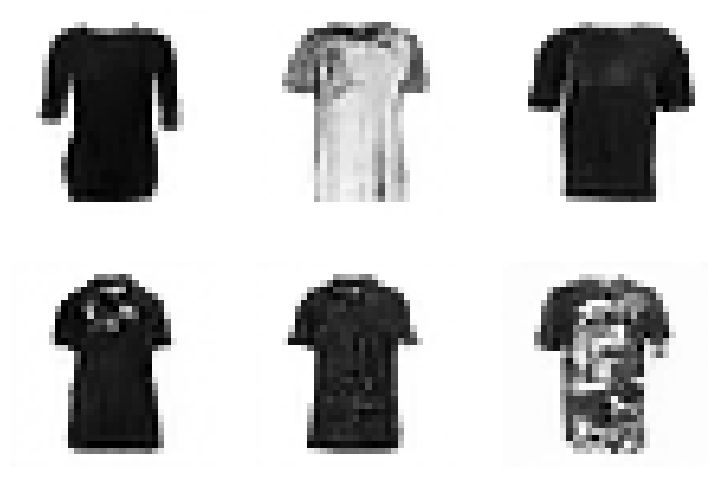

In [22]:
images = generate_from_class(0)
show_images(images, nrows=2)

1000it [00:48, 20.72it/s]


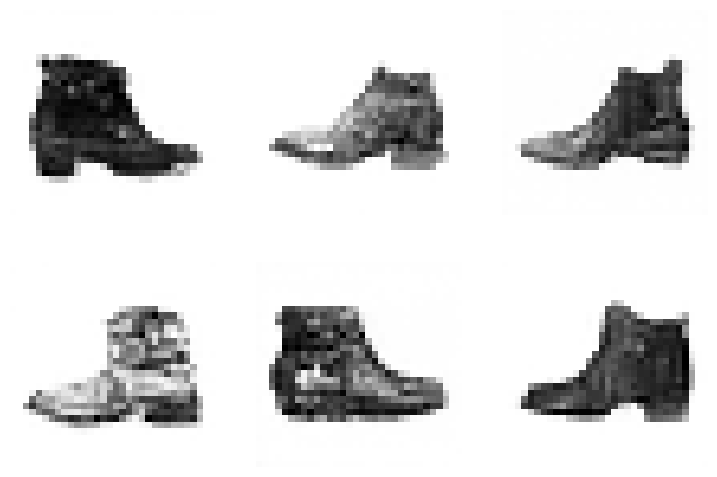

In [23]:
images = generate_from_class(9)
show_images(images, nrows=2)